In [1]:
import pandas as pd
import datetime

interest_rates = pd.read_csv('Interest_rates.csv')
interest_rates['date'] = pd.to_datetime(interest_rates['date'], dayfirst=True)
interest_rates = interest_rates[interest_rates['date'] >= datetime.datetime(2021, 1, 1)]

In [2]:
dates = interest_rates.reset_index()['date'].tolist()
rates = interest_rates['interest_rate'].tolist()

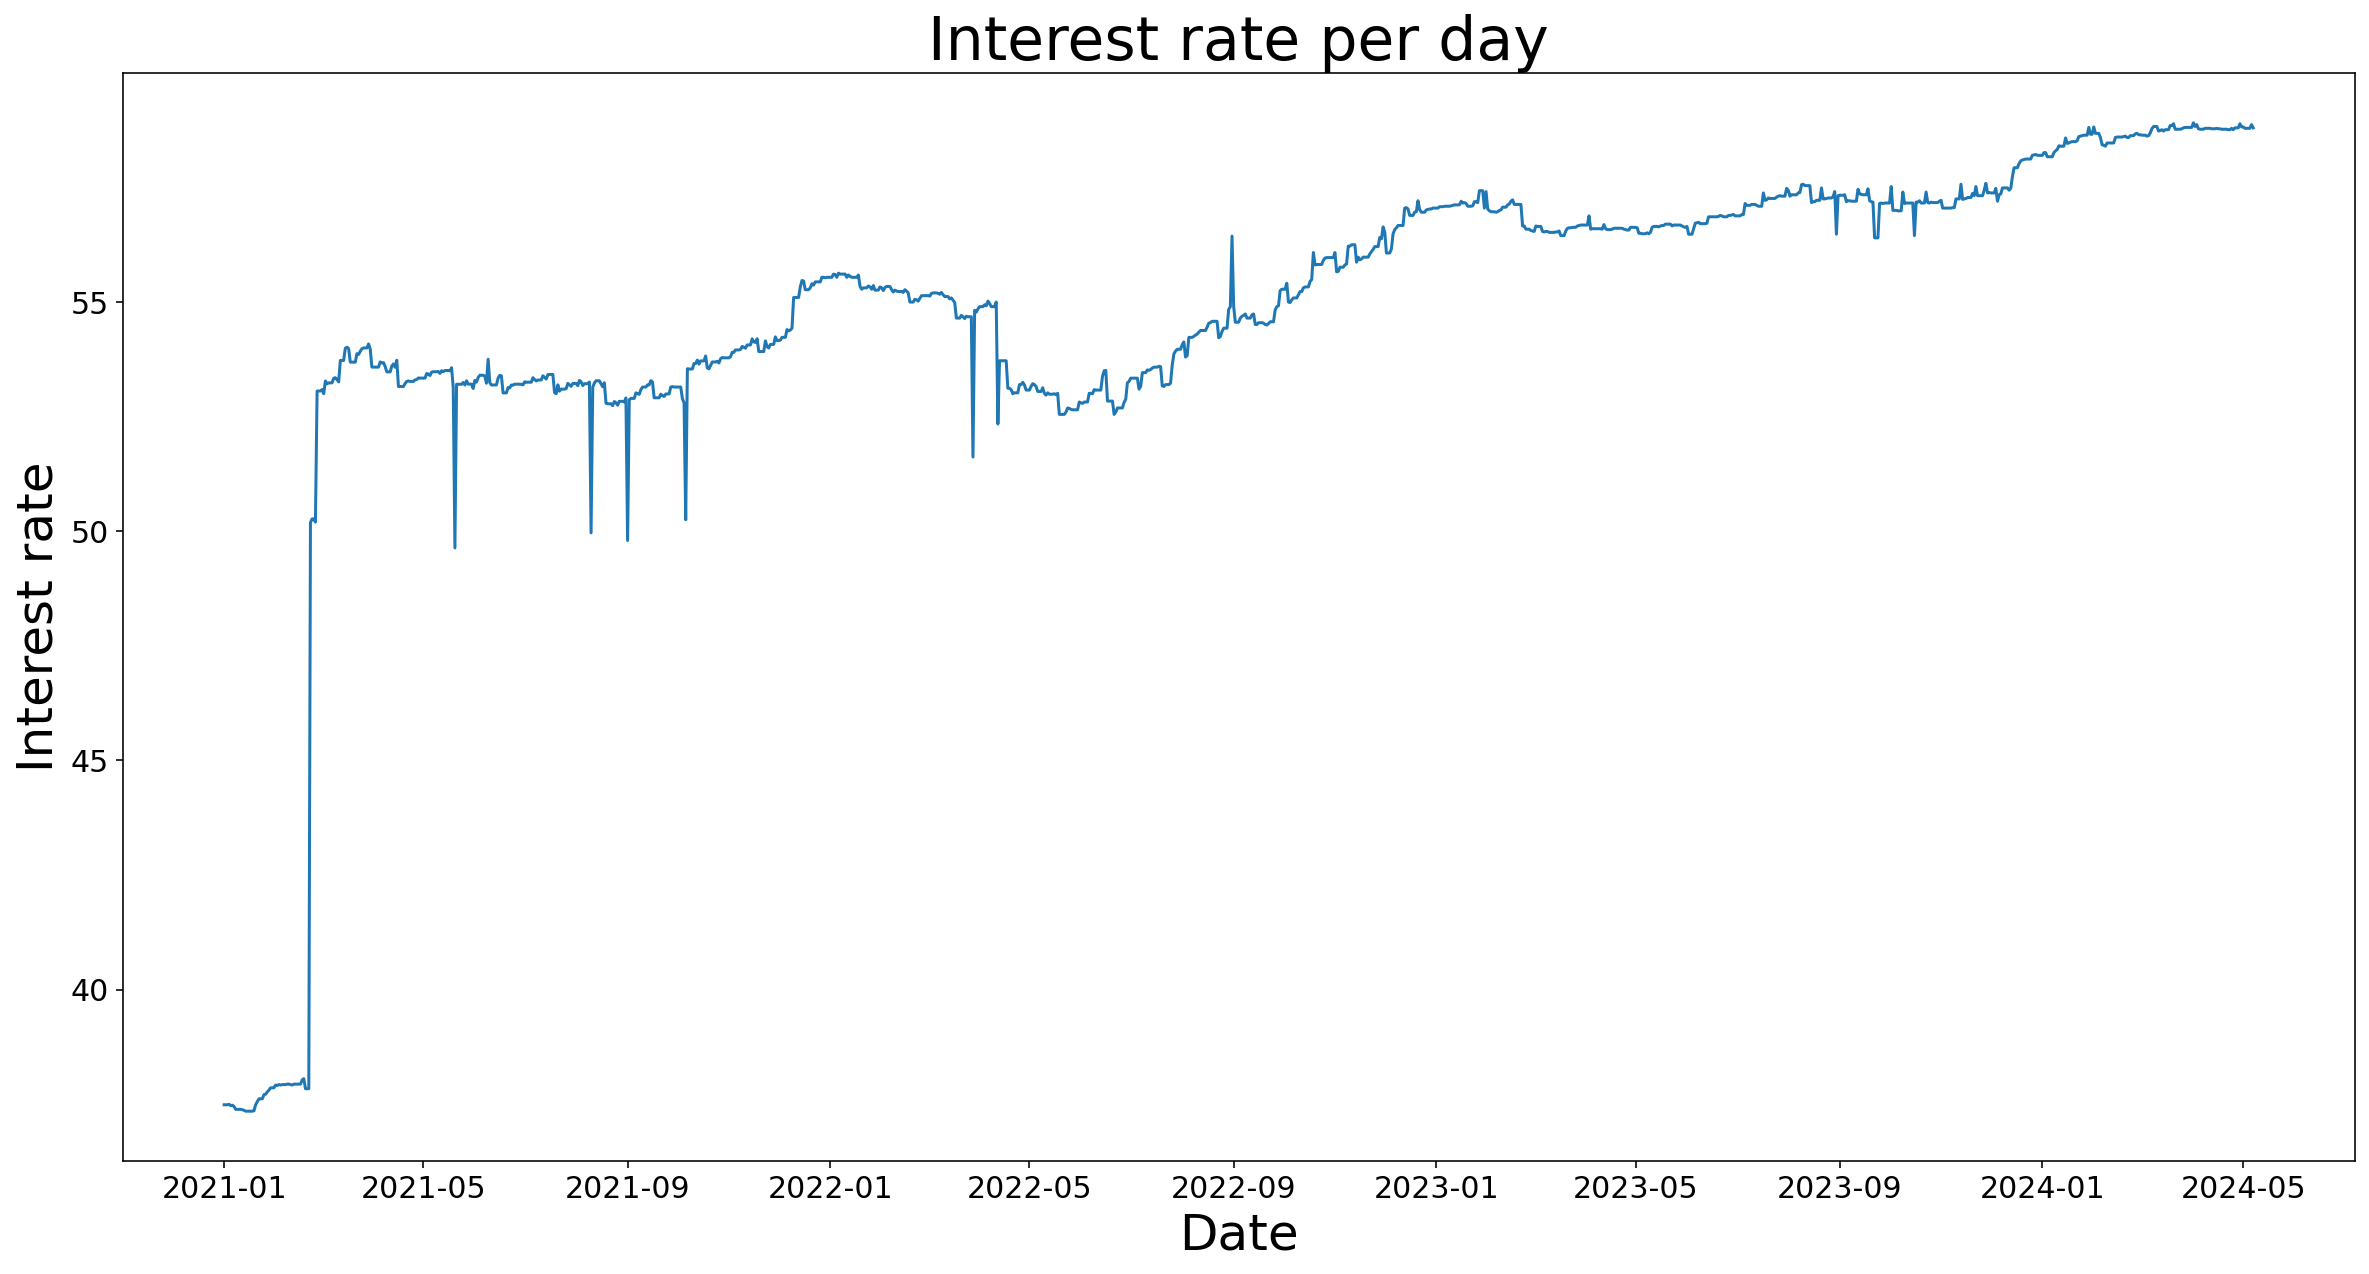

In [3]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 20, 10

plt.plot(dates, rates)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Interest rate', fontsize = 25)
plt.title('Interest rate per day', fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

period = 128
train, test = train_test_split(rates, test_size=period, shuffle=False)
train_dates, test_dates = train_test_split(dates, test_size=period, shuffle=False)
train, val = train_test_split(train, test_size=period, shuffle=False)
train_dates, val_dates = train_test_split(train_dates, test_size=period, shuffle=False)

In [5]:
from statsmodels.tsa.stattools import adfuller

d = 0
if adfuller(train)[1] >= 0.05:
    print('Data is not stationary')
    d += 1
else:
    print('Data is stationary')

Data is stationary


### Auto ARIMA implementation. ###

In [6]:
from pmdarima.arima import auto_arima

model = auto_arima(train+val, max_p=5, d=d, max_q=15, max_order=30, seasonal=False, stepwise=False)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1095
Model:               SARIMAX(1, 0, 4)   Log Likelihood                -805.133
Date:                Mon, 20 May 2024   AIC                           1622.265
Time:                        21:15:43   BIC                           1652.256
Sample:                             0   HQIC                          1633.613
                               - 1095                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   5322.177      0.000       1.000       1.000
ma.L1         -0.2068      0.007    -31.068      0.000      -0.220      -0.194
ma.L2         -0.0020      0.030     -0.068      0.9

In [7]:
auto_arima_order = (model.get_params()['order'])
auto_arima_order

(1, 0, 4)

In [8]:
from sklearn.metrics import mean_squared_error

test_pred = model.predict(period)
test_RMSE = mean_squared_error(test, test_pred, squared=False)
test_rel_error = ((abs(test - test_pred)) / test) * 100

print("Test RMSE = %.3f" % test_RMSE, sep="")
print("Test relative error = %.3f" % test_rel_error.mean(), '%', sep="")
print("Last test relative error = %.3f" % test_rel_error[-1], '%', sep="")

Test RMSE = 0.679
Test relative error = 1.067%
Last test relative error = 1.591%


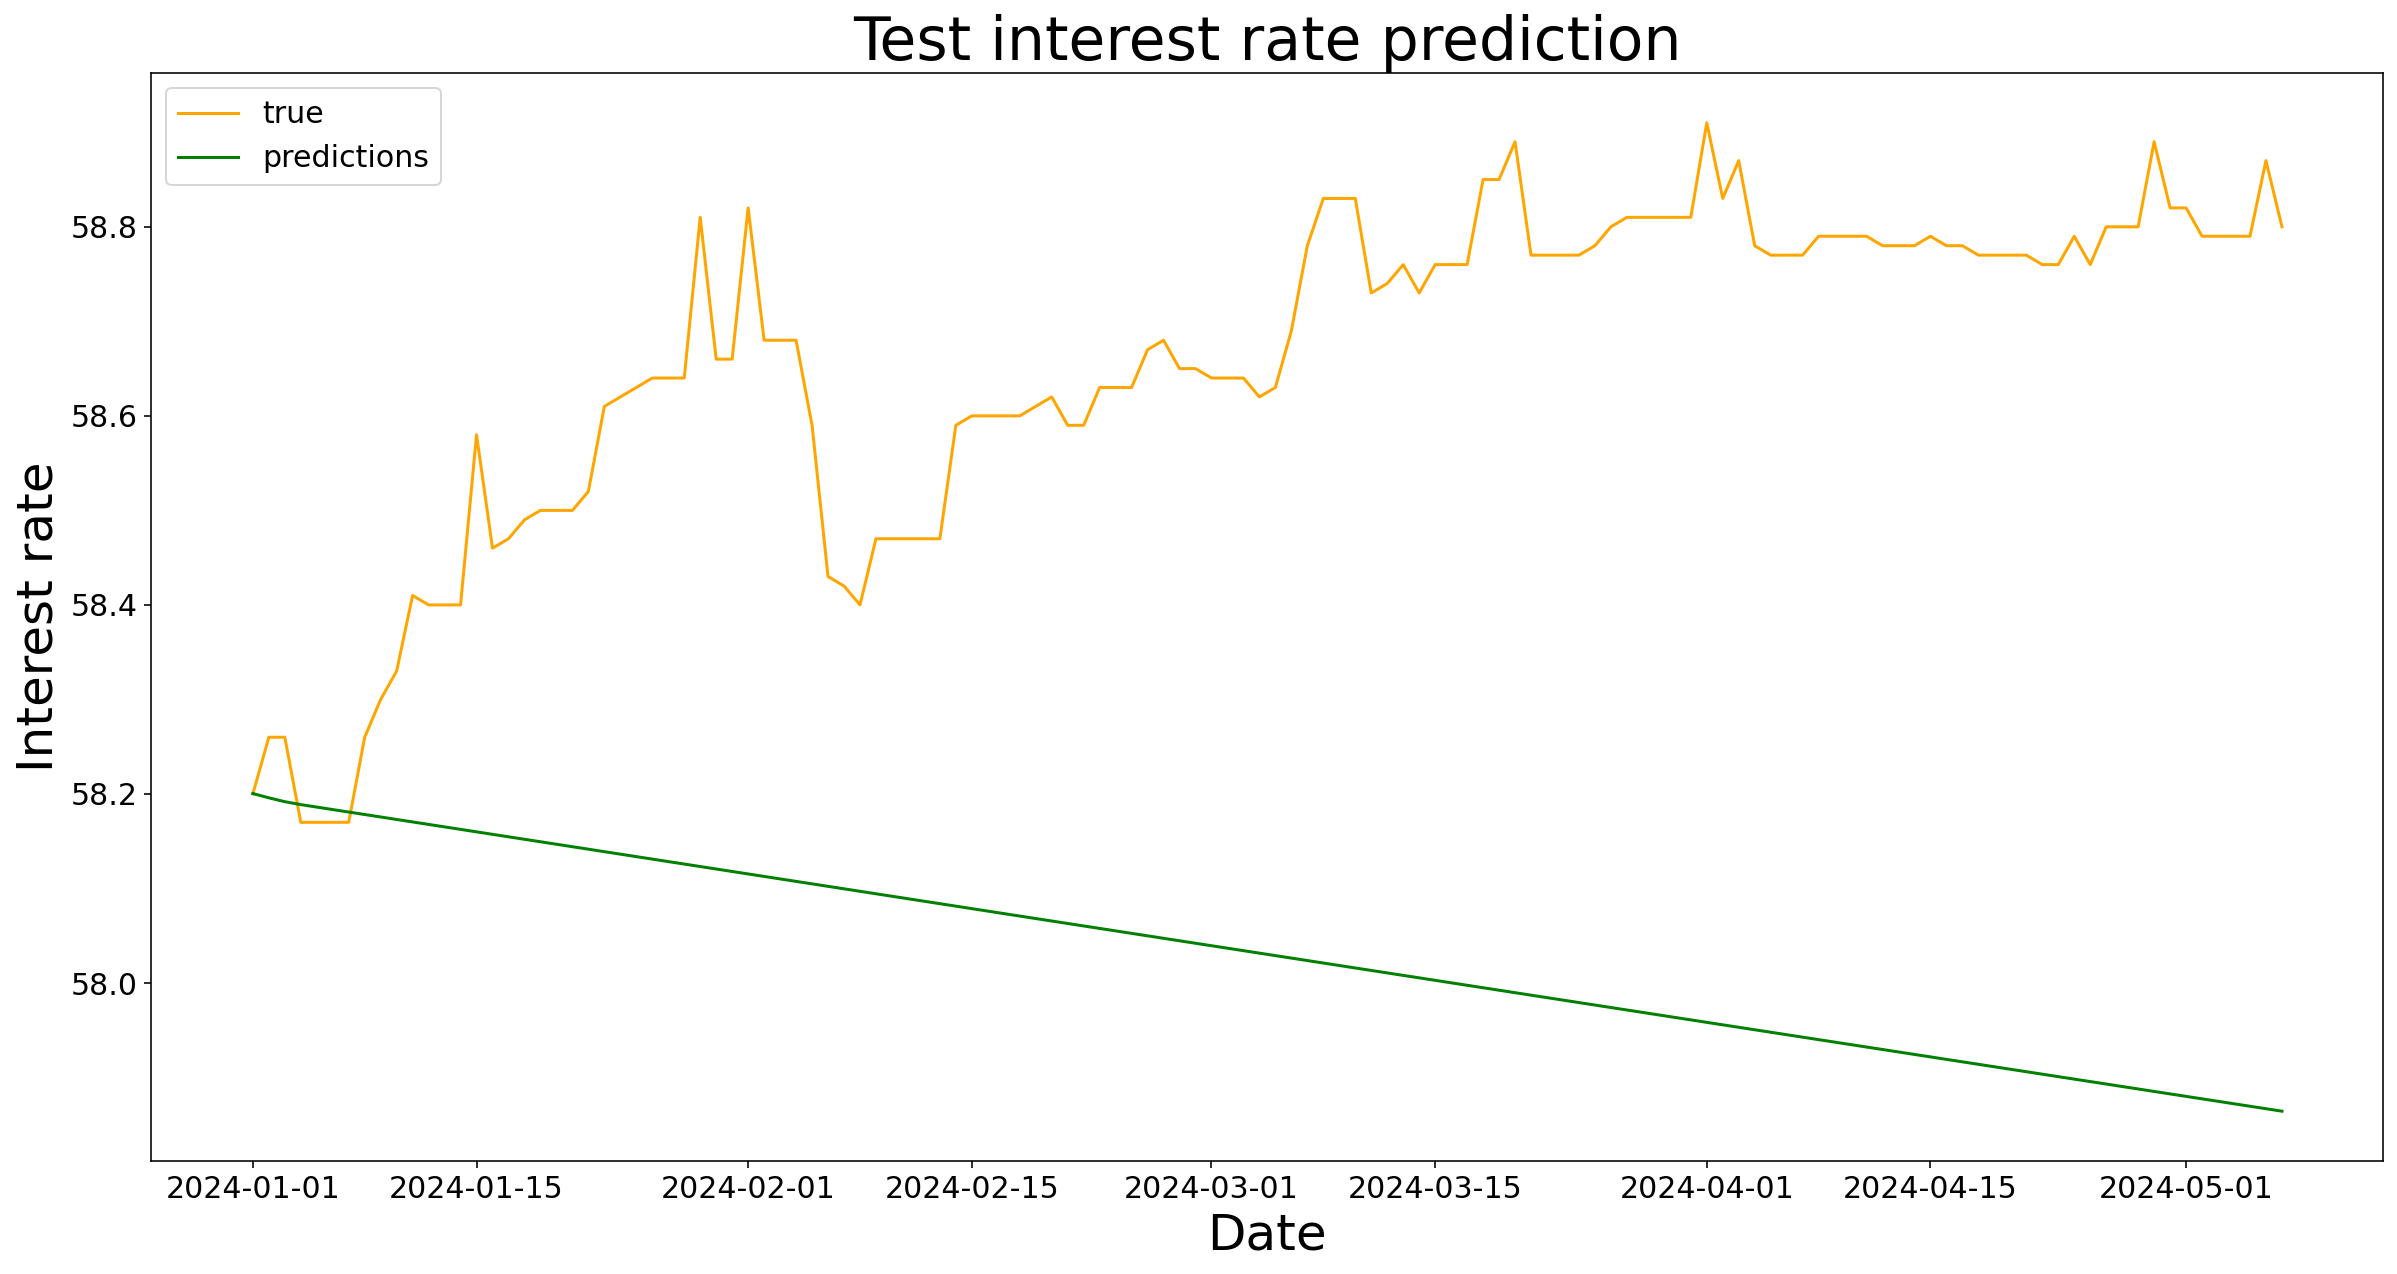

In [9]:
plt.plot(test_dates, test, color = 'orange', label = 'true')
plt.plot(test_dates, test_pred, color = 'green', label = 'predictions')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Interest rate", fontsize = 25)
plt.title("Test interest rate prediction", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

### Now lets tune p, d, r parameters with grid search. ###

/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


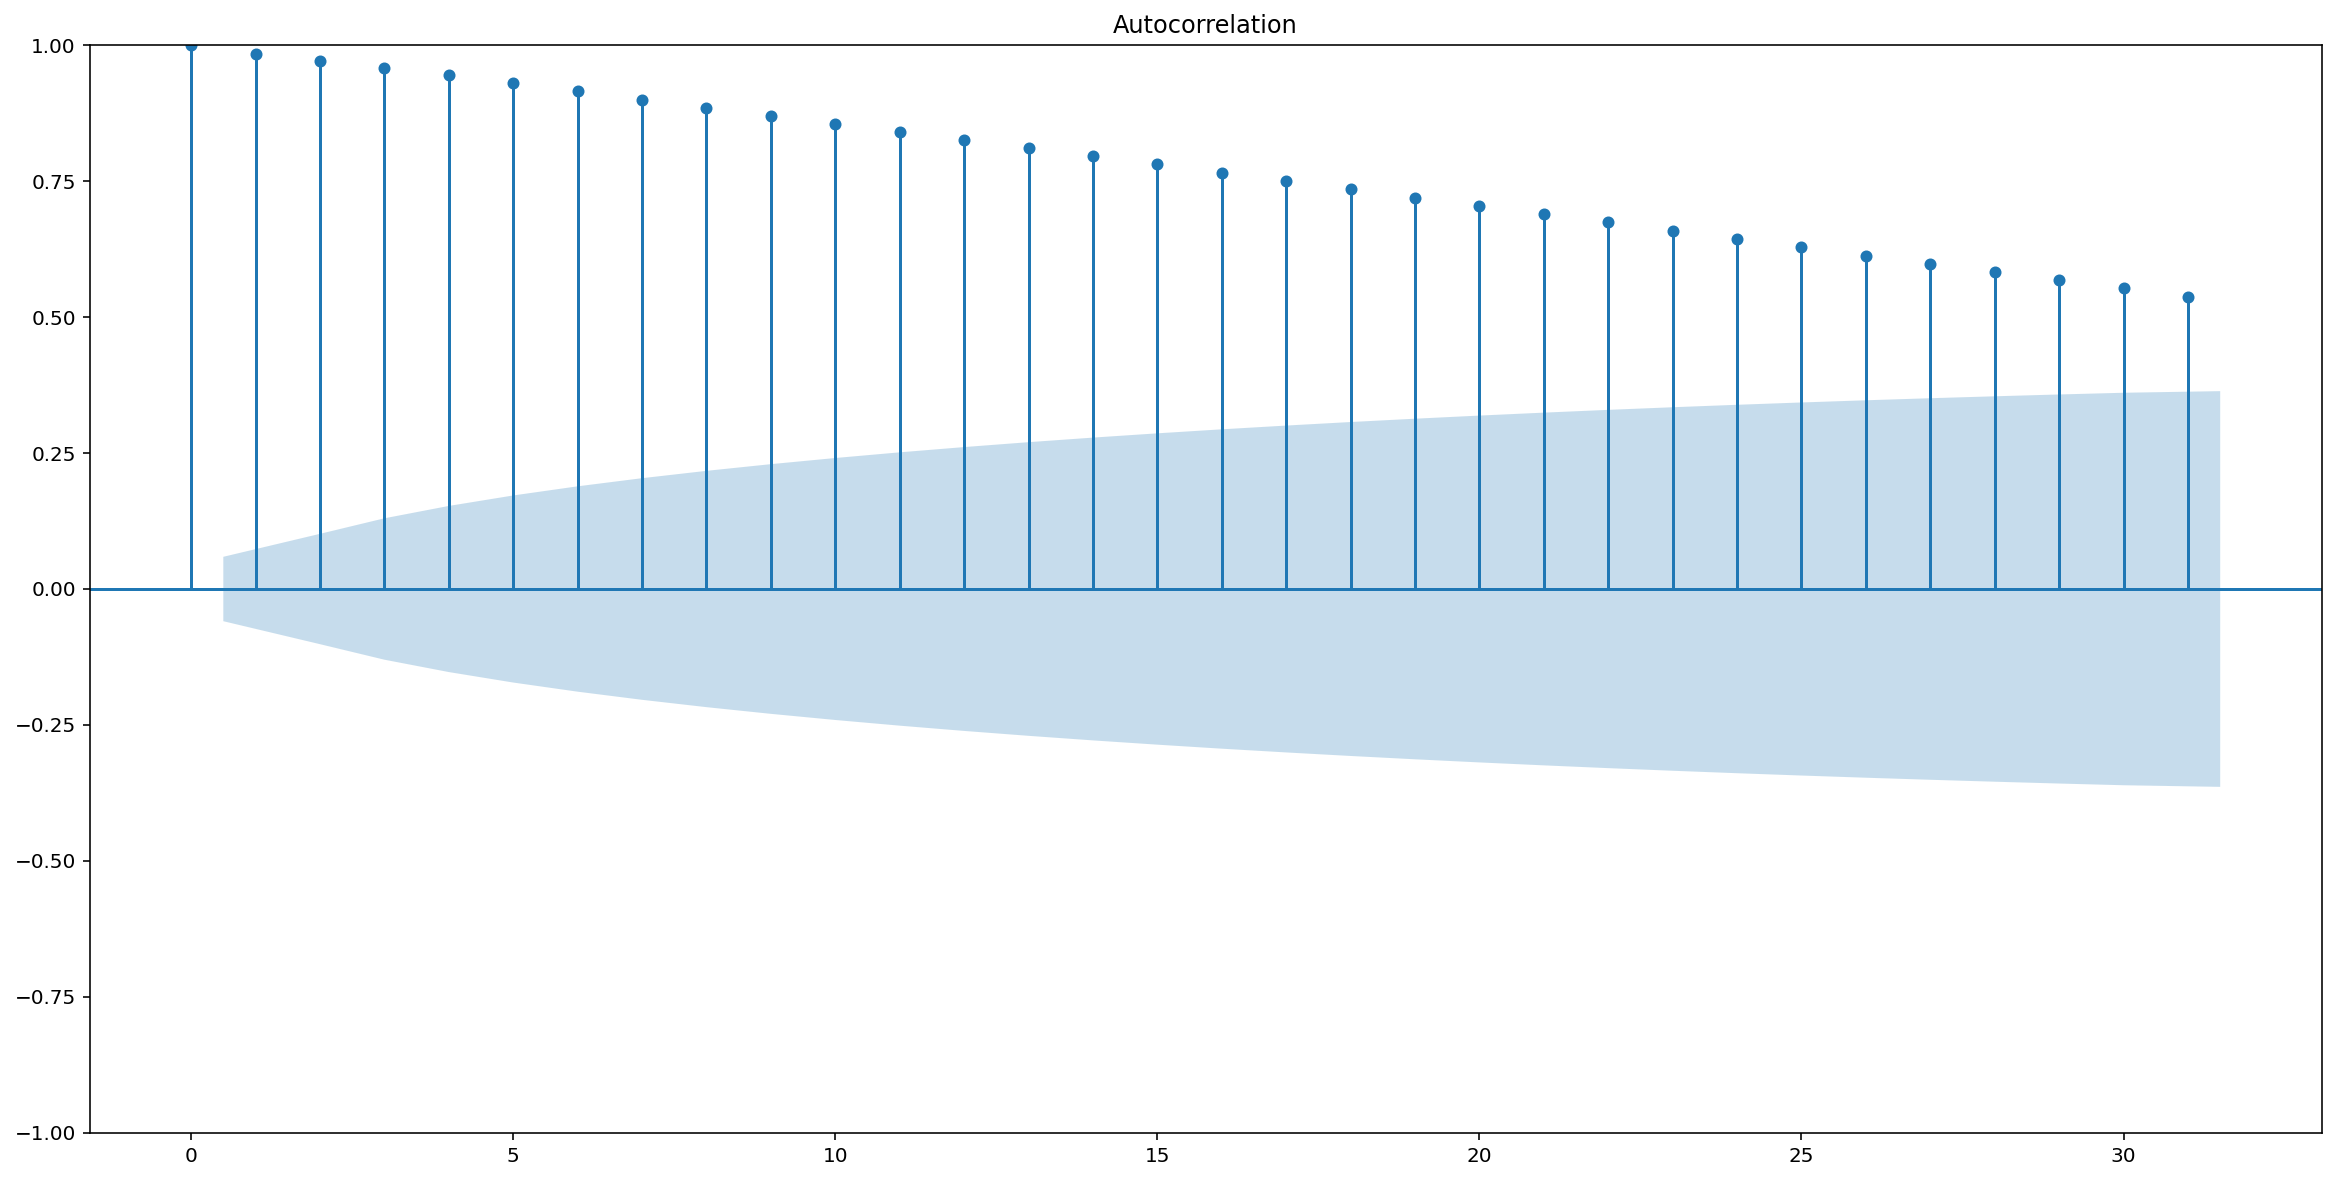

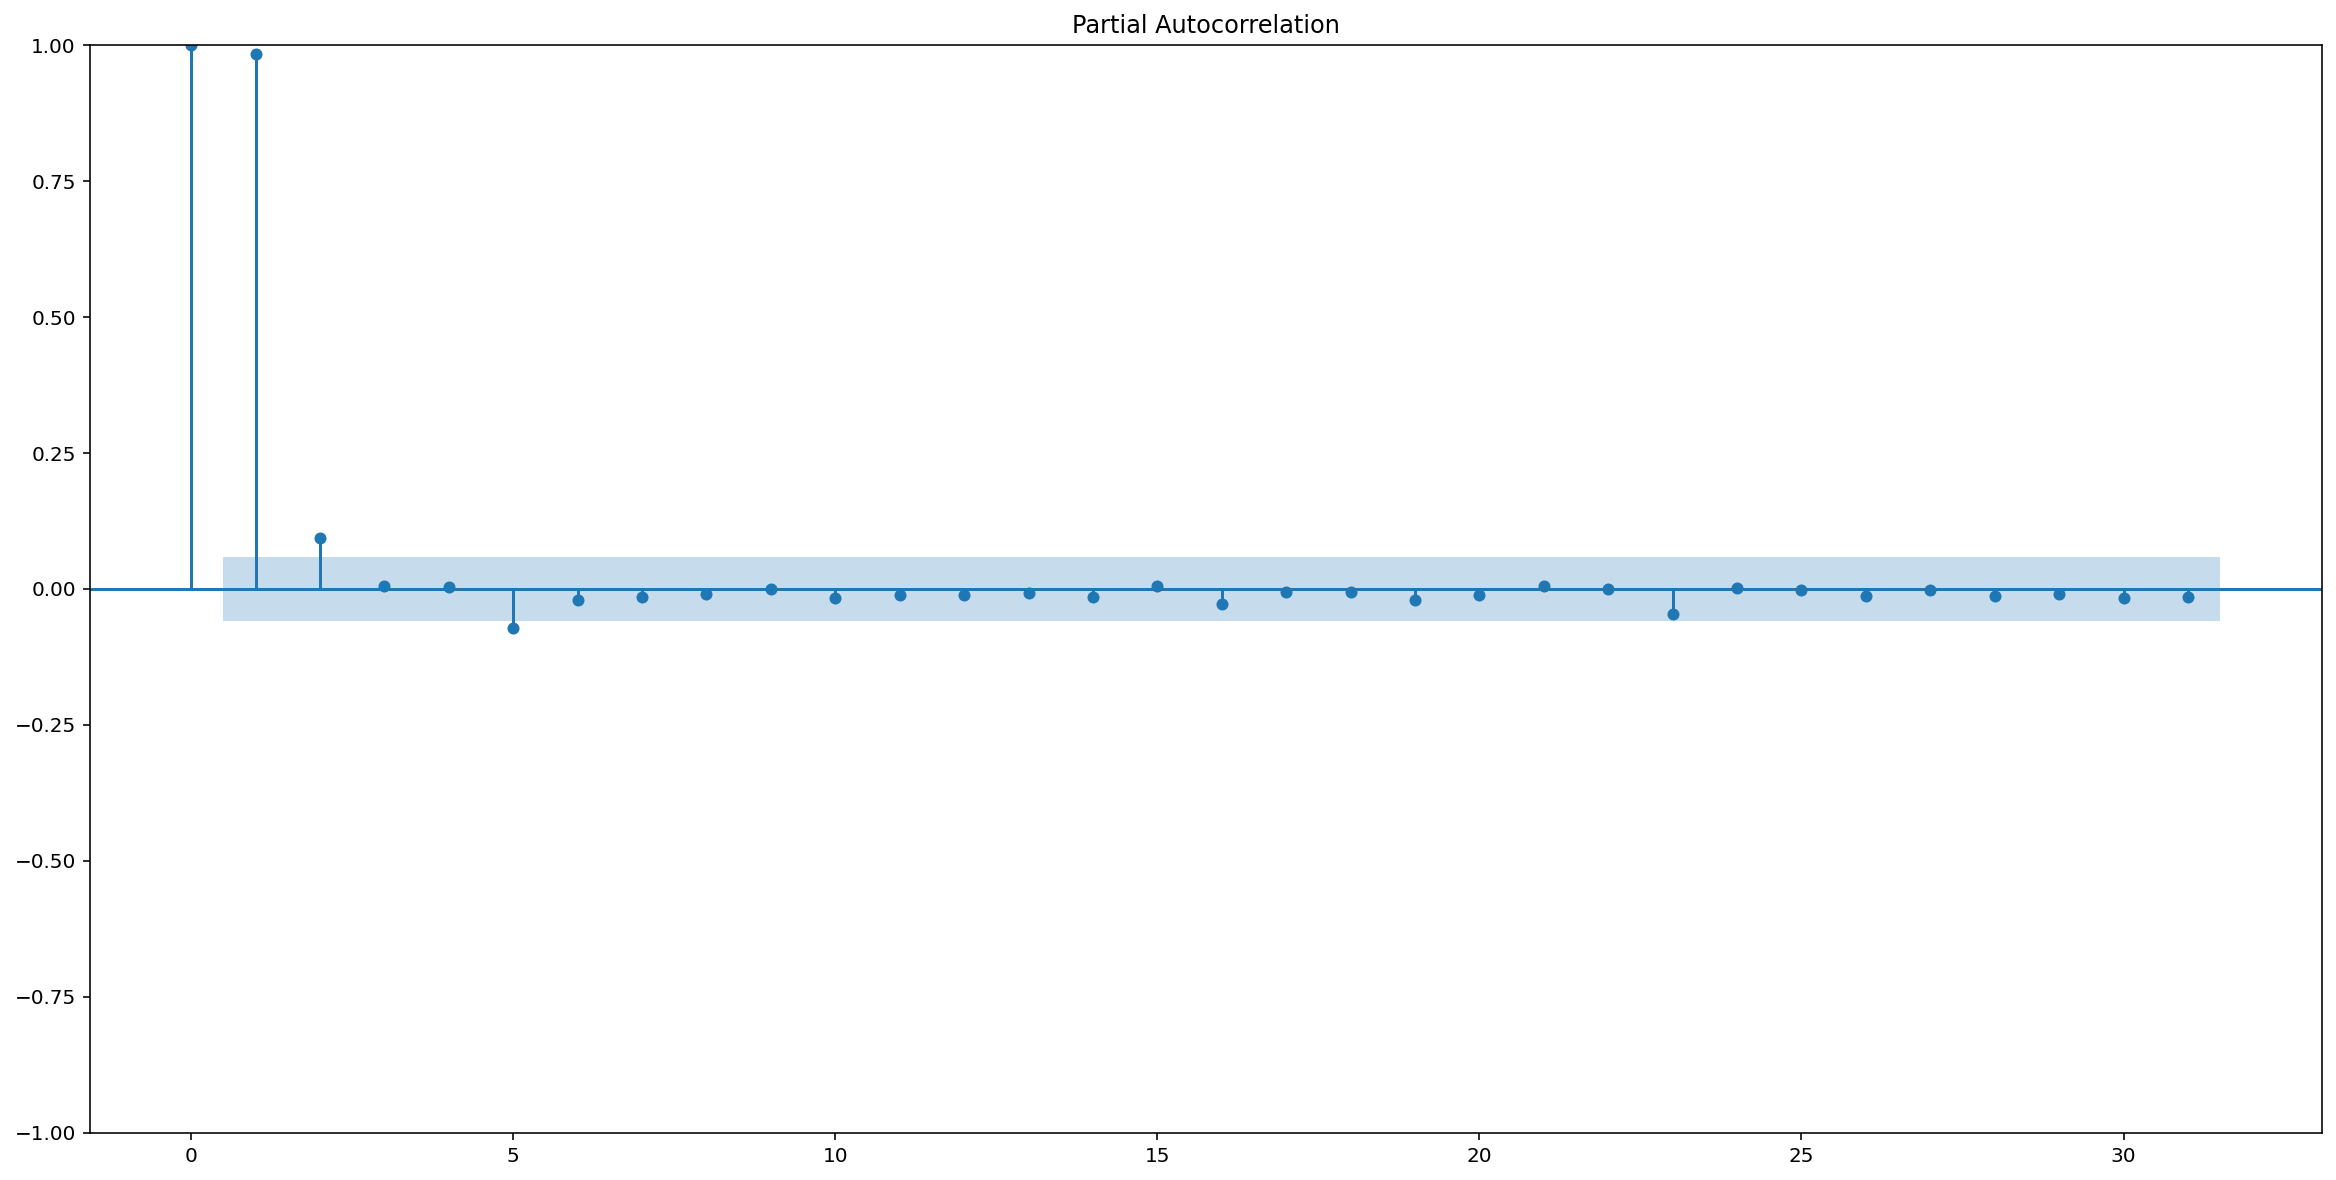

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(interest_rates['interest_rate'][:-period])
plot_pacf(interest_rates['interest_rate'][:-period])
plt.show()

In [11]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
import numpy as np

p_values = range(0, 6)
q_values = range(0, 16)
best_RMSE = np.inf
best_arima_order = (0, 0, 0)

for p_ in p_values:
    for q_ in q_values:
        warnings.filterwarnings("ignore")
        order_ = (p_,d,q_)
        model_ = ARIMA(train, order=order_).fit()
        val_pred_ = model_.forecast(period)
        val_RMSE_ = mean_squared_error(val, val_pred_, squared=False)
        if val_RMSE_ < best_RMSE:
            best_RMSE = val_RMSE_
            best_arima_order = order_

print("Best RMSE = %.3f" % best_RMSE, sep="")
print("Best arima order = ", best_arima_order, sep="")

Best RMSE = 0.381
Best arima order = (3, 0, 11)


In [12]:
best_model = ARIMA(train, order=best_arima_order).fit()
val_pred_ = best_model.forecast(period)
val_RMSE_ = mean_squared_error(val, val_pred_, squared=False)
val_rel_error_ = ((abs(val - val_pred_)) / val) * 100
print("Validation RMSE = %.3f" % val_RMSE_, sep="")
print("Validation relative error = %.3f" % val_rel_error_.mean(), '%', sep="")
print("Last validation relative error = %.3f" % val_rel_error_[-1], '%', sep="")

Validation RMSE = 0.381
Validation relative error = 0.428%
Last validation relative error = 1.637%


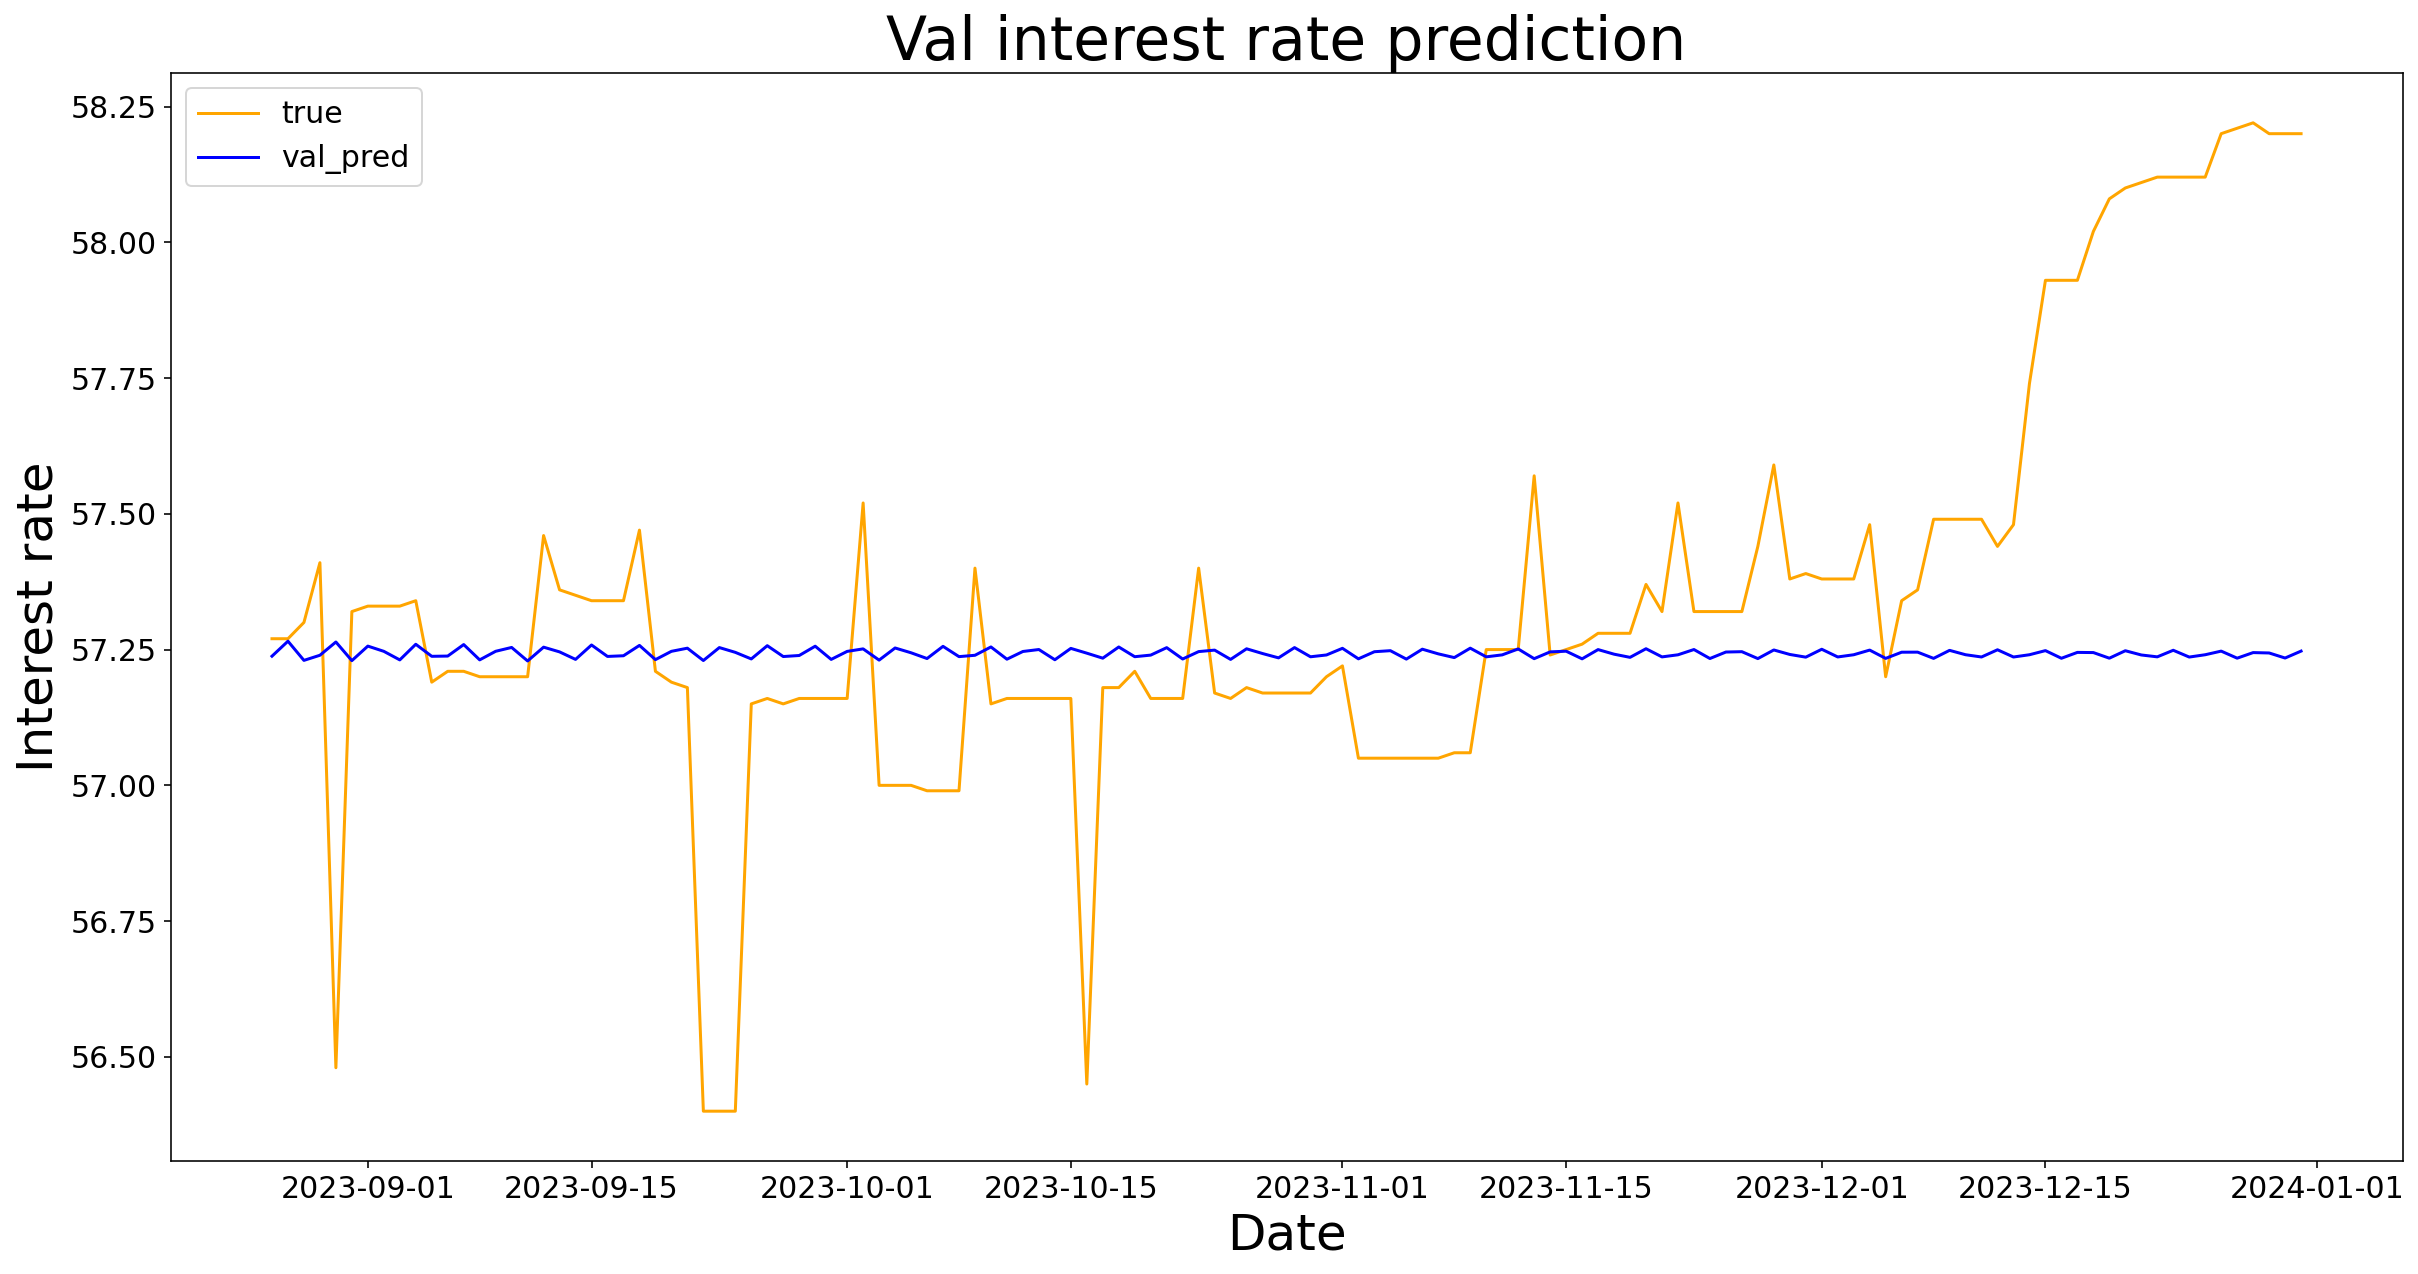

In [13]:
plt.title("Val interest rate prediction", fontsize = 30)
plt.plot(val_dates, val, color = 'orange', label = 'true')
plt.plot(val_dates, val_pred_, color = 'blue', label = 'val_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Interest rate", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize=15)
plt.show()

In [14]:
best_model = ARIMA(train+val, order=best_arima_order).fit()
test_pred_ = best_model.forecast(period)
test_RMSE_ = mean_squared_error(test, test_pred_, squared=False)
test_rel_error_ = ((abs(test - test_pred_)) / test) * 100
print("Test RMSE = %.3f" % test_RMSE_, sep="")
print("Test relative error = %.3f" % test_rel_error_.mean(), '%', sep="")
print("Last test relative error = %.3f" % test_rel_error_[-1], '%', sep="")

Test RMSE = 0.488
Test relative error = 0.777%
Last test relative error = 1.002%


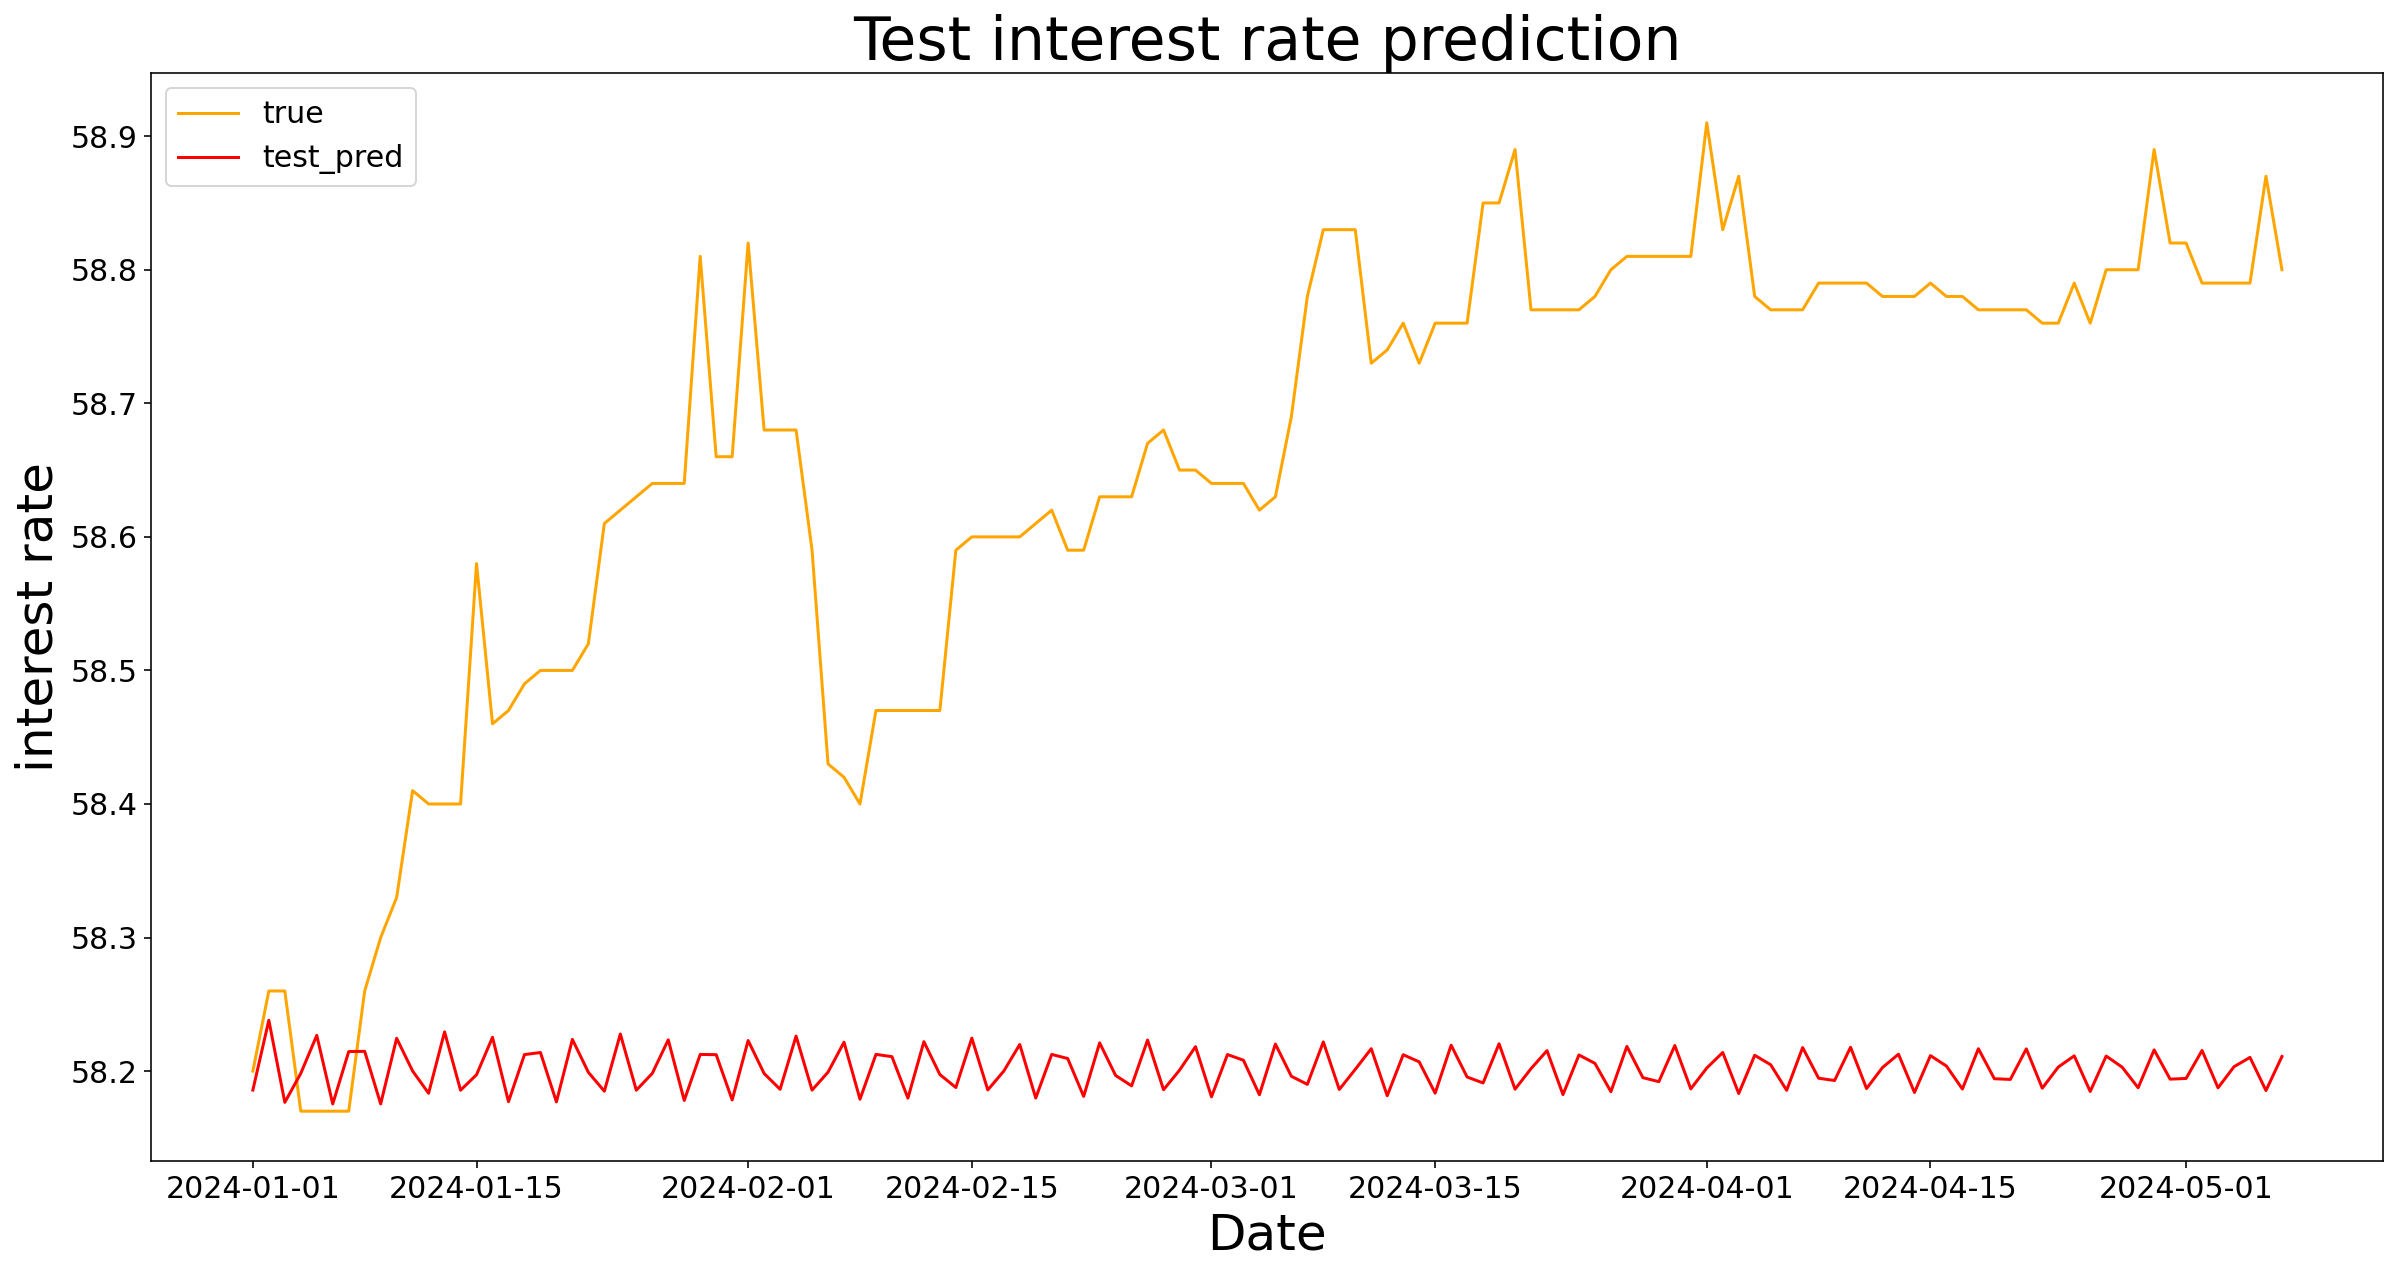

In [15]:
plt.plot(test_dates, test, color = 'orange', label = 'true')
plt.plot(test_dates, test_pred_, color = 'red', label = 'test_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("interest rate", fontsize = 25)
plt.title("Test interest rate prediction", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize=15)
plt.show()